# gpOptimizer.Optimize: A Simple Black-Box Optimization

This is the new test for gpCAM version 8.1.3 and later.

In [1]:
##first install the right version of gpCAM
#!pip install gpcam==8.1.4

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

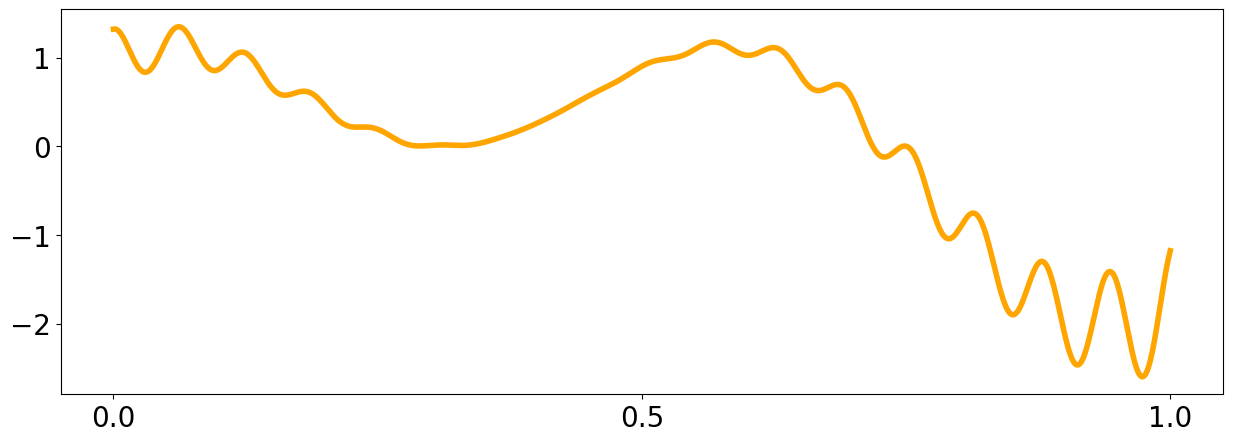

In [4]:

def f1(x):
    if np.ndim(x) == 1: return (np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)), 0.01
    else: return (np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x))[:,0], np.zeros(len(x)) + 0.01

def f2(x):
    if np.ndim(x) == 1: return -(np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)), 0.01
    else: return -(np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x))[:,0], np.zeros(len(x)) + 0.01

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D)[0], color = 'orange', linewidth = 4)

## Initialization and Optimization

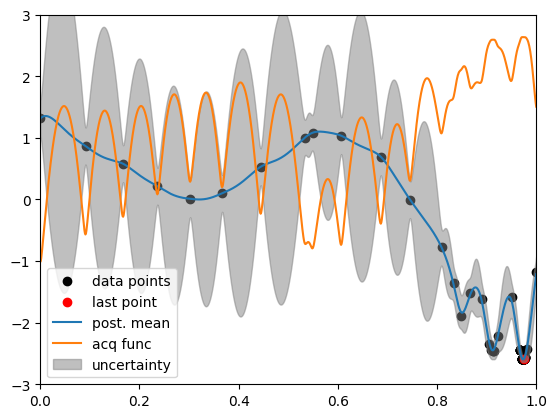

In [5]:
from IPython.display import clear_output
my_gp1 = GPOptimizer()
def callb(x,y):
    clear_output(wait=True)
    plt.scatter(x, y, color = 'black', label = "data points")
    plt.scatter(x[-1], y[-1], color = 'red', label = "last point")
    m = my_gp1.posterior_mean(x_pred1D)["f(x)"]
    s = np.sqrt(my_gp1.posterior_covariance(x_pred1D)["v(x)"])
    plt.plot(x_pred1D, m, label = "post. mean")
    plt.plot(x_pred1D, -(m-3.*s), label =  "acq func")
    plt.fill_between(x_pred1D.flatten(), m-3.*s, m+3.*s, label = "uncertainty", color = "grey", alpha = .5)
    plt.xlim([0,1])
    plt.ylim(-3,3)
    plt.legend(loc = 'lower left')
    plt.show()
    
result = my_gp1.optimize(func = f1, search_space =  np.array([[0,1]]), callback=callb)
